In [1]:
from fastai.vision.all import *

In [2]:
import torch
from torch import tensor
from torchvision.models.resnet import resnet34
import requests

import pandas as pd
from fastcore.transform import Pipeline
from fastcore.xtras import Path

from fastai.data.core import Datasets
from fastai.data.block import DataBlock, MultiCategoryBlock
from fastai.vision.data import ImageBlock
from fastai.data.external import URLs, untar_data
from fastai.data.transforms import (
    ColReader,
    IntToFloatTensor, 
    MultiCategorize,
    Normalize, 
    OneHotEncode, 
    RandomSplitter,
    RegexLabeller,
    get_image_files
)

from fastai.metrics import accuracy_multi

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import PILImage
from fastai.vision.learner import vision_learner
from fastai.learner import Learner
from fastai.callback.schedule import Learner

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [5]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [6]:
def label_to_list(o): return [o]

In [7]:
multi_pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=Pipeline(
        [RegexLabeller(pat = r'/([^/]+)_\d+.*'), label_to_list]
    ),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [8]:
dls = multi_pets.dataloaders(path, bs=32)

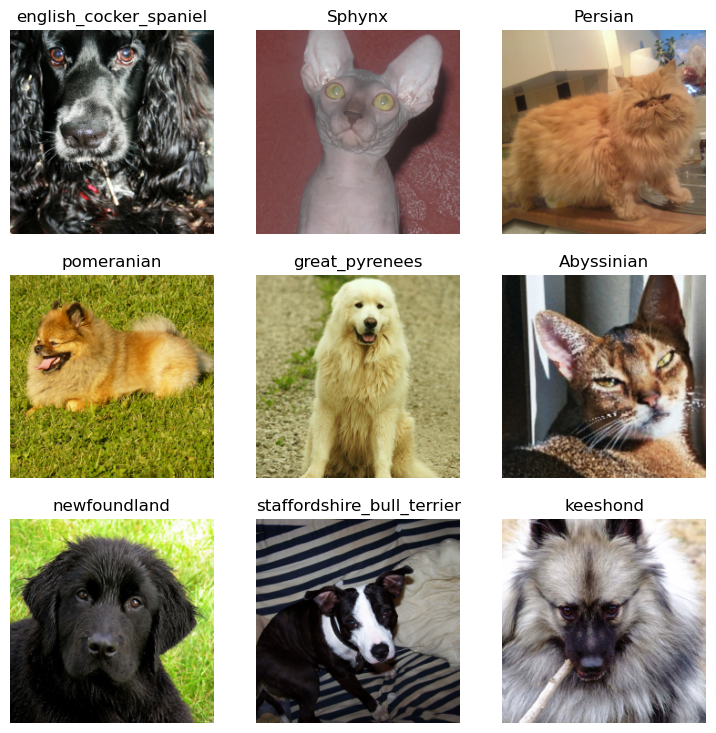

In [9]:
dls.show_batch()

In [10]:
train_idxs, valid_idxs = RandomSplitter()(get_image_files(path))

In [11]:
tfms = [
    [PILImage.create],
    [
        RegexLabeller(pat = r'/([^/]+)_\d+.*'),
        label_to_list,
        MultiCategorize(vocab=list(dls.vocab)),
        OneHotEncode(len(dls.vocab))
    ]
]

In [12]:
dsets = Datasets(get_image_files(path), tfms=tfms, splits=[train_idxs, valid_idxs])

In [13]:
dsets[0]

(PILImage mode=RGB size=374x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0.]))

In [14]:
dls = dsets.dataloaders(
    after_item=[ToTensor(), RandomResizedCrop(460, min_scale=.75)],
    after_batch=[IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)],
    bs=32
)

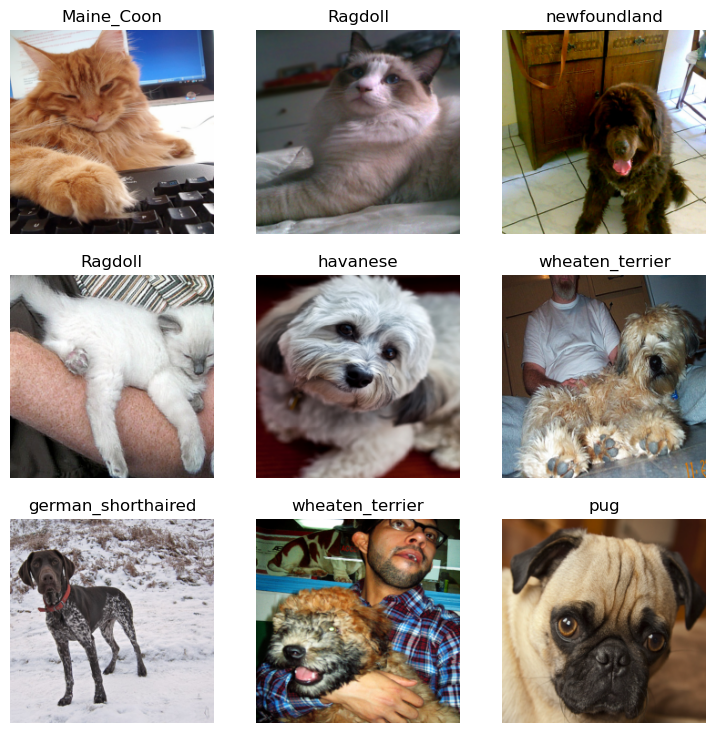

In [15]:
dls.show_batch()

In [16]:
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.95)])

/home/jcarnero/.miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jcarnero/.miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
learn.fine_tune(4, 2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.053577,0.024363,0.980544,00:08
1,0.025971,0.015155,0.988041,00:08
2,0.015570,0.011166,0.991826,00:07
3,0.010332,0.010838,0.992539,00:08


In [18]:
learn.loss_func.thresh = 0.95

In [19]:
PERSIAN_CAT_URL = "https://azure.wgp-cdn.co.uk/app-yourcat/posts/iStock-174776419-1.jpg"

In [20]:
response = requests.get(PERSIAN_CAT_URL)
im = PILImage.create(response.content)

<Axes: >

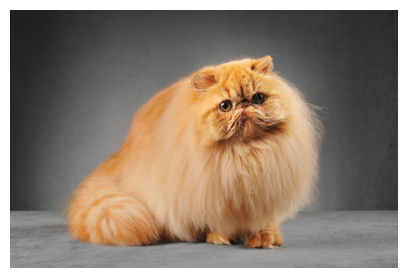

In [21]:
im.show()

In [22]:
with tempfile.NamedTemporaryFile(mode="wb") as jpg:
    jpg.write(response.content)
    print(learn.predict(jpg.name)[0])

['Persian']


In [23]:
DONKEY_URL = "https://cdn.britannica.com/68/143568-050-5246474F/Donkey.jpg"

In [24]:
response = requests.get(DONKEY_URL)
im = PILImage.create(response.content)

<Axes: >

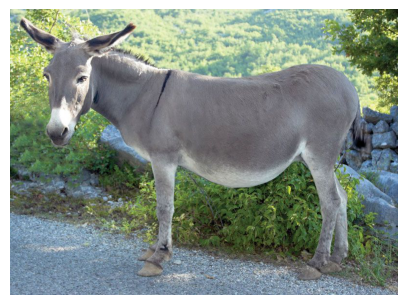

In [25]:
im.show()

In [26]:
with tempfile.NamedTemporaryFile(mode="wb") as jpg:
    jpg.write(response.content)
    print(learn.predict(jpg.name)[0])

[]
